[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/utkarshp1161/Active-learning-in-microscopy/blob/main/notebooks/0b_getting_started_BI-sGP.ipynb)
# Bayesian Inference on 2-Gaussian Peaks using Structured GP: Tutorial

- Written in Gpytorch and Botorch by [Utkarsh Pratiush](https://github.com/utkarshp1161)
    - With help of chatgpt


# 0. Install and imports

In [ ]:
#install
!pip install -q botorch==0.12.0
!pip install -q gpytorch==1.13


In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
from gpytorch.constraints import Positive, Interval
from gpytorch.priors import LogNormalPrior, NormalPrior
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


# 1. GROUND TRUTH FUNCTION: 2 Gaussian Peaks

In [2]:
def ground_truth_function(x):
    """Two Gaussian peaks with different heights and positions"""
    x = np.asarray(x)
    peak1 = 3.0 * np.exp(-0.5 * ((x - 2.0) / 0.5)**2)  # Peak at x=2, height=3, width=0.5
    peak2 = 2.0 * np.exp(-0.5 * ((x - 6.0) / 0.8)**2)  # Peak at x=6, height=2, width=0.8
    return peak1 + peak2 + 0.1  # Small baseline

def noisy_measurement(x, noise_std=0.1):
    """Add Gaussian noise to measurements"""
    if torch.is_tensor(x):
        x = x.detach().numpy()
    return ground_truth_function(x) + np.random.normal(0, noise_std, x.shape)


# 2. STRUCTURED MEAN FUNCTION: 2-Gaussian Prior


In [3]:
class TwoGaussianMean(gpytorch.means.Mean):
    """Mean function representing sum of two Gaussians"""
    
    def __init__(self):
        super().__init__()
        
        # Peak 1 parameters
        self.register_parameter(
            name="raw_amp1", 
            parameter=torch.nn.Parameter(torch.tensor(1.0))
        )
        self.register_parameter(
            name="raw_center1", 
            parameter=torch.nn.Parameter(torch.tensor(2.0))
        )
        self.register_parameter(
            name="raw_width1", 
            parameter=torch.nn.Parameter(torch.tensor(0.0))  # log(1.0)
        )
        
        # Peak 2 parameters
        self.register_parameter(
            name="raw_amp2", 
            parameter=torch.nn.Parameter(torch.tensor(0.5))
        )
        self.register_parameter(
            name="raw_center2", 
            parameter=torch.nn.Parameter(torch.tensor(6.0))
        )
        self.register_parameter(
            name="raw_width2", 
            parameter=torch.nn.Parameter(torch.tensor(0.0))  # log(1.0)
        )
        
        # Baseline
        self.register_parameter(
            name="raw_baseline", 
            parameter=torch.nn.Parameter(torch.tensor(-2.0))  # log(0.1)
        )
        
        # Constraints
        self.register_constraint("raw_amp1", Positive())
        self.register_constraint("raw_amp2", Positive())
        self.register_constraint("raw_center1", Interval(0.0, 8.0))
        self.register_constraint("raw_center2", Interval(0.0, 8.0))
        self.register_constraint("raw_width1", Positive())
        self.register_constraint("raw_width2", Positive())
        self.register_constraint("raw_baseline", Positive())
        
        # Priors - encoding our beliefs about the parameters
        self.register_prior(
            "amp1_prior", LogNormalPrior(1.0, 0.5),  # Peak 1 amplitude
            lambda m: m.amp1, lambda m, v: m._set_amp1(v)
        )
        self.register_prior(
            "amp2_prior", LogNormalPrior(0.5, 0.5),  # Peak 2 amplitude
            lambda m: m.amp2, lambda m, v: m._set_amp2(v)
        )
        self.register_prior(
            "center1_prior", NormalPrior(2.0, 1.0),  # Peak 1 center
            lambda m: m.center1, lambda m, v: m._set_center1(v)
        )
        self.register_prior(
            "center2_prior", NormalPrior(6.0, 1.0),  # Peak 2 center
            lambda m: m.center2, lambda m, v: m._set_center2(v)
        )
        self.register_prior(
            "width1_prior", LogNormalPrior(0.0, 0.3),  # Peak 1 width
            lambda m: m.width1, lambda m, v: m._set_width1(v)
        )
        self.register_prior(
            "width2_prior", LogNormalPrior(0.0, 0.3),  # Peak 2 width
            lambda m: m.width2, lambda m, v: m._set_width2(v)
        )
        self.register_prior(
            "baseline_prior", LogNormalPrior(-2.0, 0.3),  # Baseline
            lambda m: m.baseline, lambda m, v: m._set_baseline(v)
        )
    
    # Properties for transformed parameters
    @property
    def amp1(self):
        return self.raw_amp1_constraint.transform(self.raw_amp1)
    
    @property
    def amp2(self):
        return self.raw_amp2_constraint.transform(self.raw_amp2)
    
    @property
    def center1(self):
        return self.raw_center1_constraint.transform(self.raw_center1)
    
    @property
    def center2(self):
        return self.raw_center2_constraint.transform(self.raw_center2)
    
    @property
    def width1(self):
        return self.raw_width1_constraint.transform(self.raw_width1)
    
    @property
    def width2(self):
        return self.raw_width2_constraint.transform(self.raw_width2)
    
    @property
    def baseline(self):
        return self.raw_baseline_constraint.transform(self.raw_baseline)
    
    # Setters
    def _set_amp1(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_amp1=self.raw_amp1_constraint.inverse_transform(value))
    
    def _set_amp2(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_amp2=self.raw_amp2_constraint.inverse_transform(value))
    
    def _set_center1(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_center1=self.raw_center1_constraint.inverse_transform(value))
    
    def _set_center2(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_center2=self.raw_center2_constraint.inverse_transform(value))
    
    def _set_width1(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_width1=self.raw_width1_constraint.inverse_transform(value))
    
    def _set_width2(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_width2=self.raw_width2_constraint.inverse_transform(value))
    
    def _set_baseline(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        self.initialize(raw_baseline=self.raw_baseline_constraint.inverse_transform(value))
    
    def forward(self, x):
        """Forward pass: sum of two Gaussians + baseline"""
        if x.ndimension() == 1:
            x = x.unsqueeze(-1)
        
        x = x.squeeze(-1)  # Remove last dimension for computation
        
        # Peak 1
        peak1 = self.amp1 * torch.exp(-0.5 * ((x - self.center1) / self.width1)**2)
        
        # Peak 2
        peak2 = self.amp2 * torch.exp(-0.5 * ((x - self.center2) / self.width2)**2)
        
        return peak1 + peak2 + self.baseline


# 3. STRUCTURED GP MODEL


In [4]:

class StructuredGP(SingleTaskGP):
    def __init__(self, train_X, train_Y):
        super().__init__(
            train_X, train_Y,
            input_transform=Normalize(d=1),
            outcome_transform=Standardize(m=1)
        )
        
        # Replace with structured mean function
        self.mean_module = TwoGaussianMean()
        
        # Use RBF kernel for residuals
        self.covar_module = ScaleKernel(RBFKernel())
        
        # Prior on kernel hyperparameters
        self.covar_module.base_kernel.register_prior(
            "lengthscale_prior",
            LogNormalPrior(0.0, 1.0),
            lambda module: module.lengthscale,
            lambda module, value: module._set_lengthscale(value)
        )
        
        self.covar_module.register_prior(
            "outputscale_prior",
            LogNormalPrior(-1.0, 1.0),
            lambda module: module.outputscale
        )
        
        # Noise prior
        self.likelihood.register_prior(
            "noise_prior",
            LogNormalPrior(-3.0, 1.0),
            lambda module: module.noise
        )


# 4. GENERATE SYNTHETIC DATA


In [5]:
x_obs = torch.tensor([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], dtype=torch.float64).reshape(-1, 1)
y_obs = torch.tensor(noisy_measurement(x_obs.numpy().flatten(), noise_std=0.15), dtype=torch.float64).reshape(-1, 1)

print(f"Generated {len(x_obs)} observations")
print(f"X range: [{x_obs.min():.2f}, {x_obs.max():.2f}]")
print(f"Y range: [{y_obs.min():.2f}, {y_obs.max():.2f}]")


Generated 8 observations
X range: [0.50, 7.50]
Y range: [0.21, 2.02]


# 5. FIT THE MODEL & RUN INFERENCE

In [6]:
# Initialize model
model = StructuredGP(x_obs, y_obs)

# Fit the model
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

print("\n" + "="*50)
print("FITTED MODEL PARAMETERS")
print("="*50)

# Print fitted parameters
mean_module = model.mean_module
print(f"Peak 1: amp={mean_module.amp1.item():.3f}, center={mean_module.center1.item():.3f}, width={mean_module.width1.item():.3f}")
print(f"Peak 2: amp={mean_module.amp2.item():.3f}, center={mean_module.center2.item():.3f}, width={mean_module.width2.item():.3f}")
print(f"Baseline: {mean_module.baseline.item():.3f}")
print(f"Kernel lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f}")
print(f"Kernel outputscale: {model.covar_module.outputscale.item():.3f}")
print(f"Noise: {model.likelihood.noise.item():.3f}")



FITTED MODEL PARAMETERS
Peak 1: amp=1.960, center=2.690, width=0.824
Peak 2: amp=1.284, center=6.001, width=0.915
Baseline: 0.121
Kernel lengthscale: 0.111
Kernel outputscale: 0.794
Noise: 0.011


# 6. POSTERIOR SAMPLING & VISUALIZATION


In [7]:

# Create test points
x_test = torch.linspace(0, 8, 200).reshape(-1, 1)
x_test_np = x_test.numpy().flatten()

# Get posterior predictions
model.eval()
with torch.no_grad():
    posterior = model.posterior(x_test)
    mean = posterior.mean.squeeze()
    std = posterior.variance.sqrt().squeeze()
    
    # Get mean function prediction
    mean_func_pred = model.mean_module(x_test).squeeze()

# Sample from posterior
num_samples = 10
with torch.no_grad():
    samples = posterior.rsample(torch.Size([num_samples])).squeeze(-1)

# Ground truth for comparison
y_true = ground_truth_function(x_test_np)


/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


# 7. PLOTTING


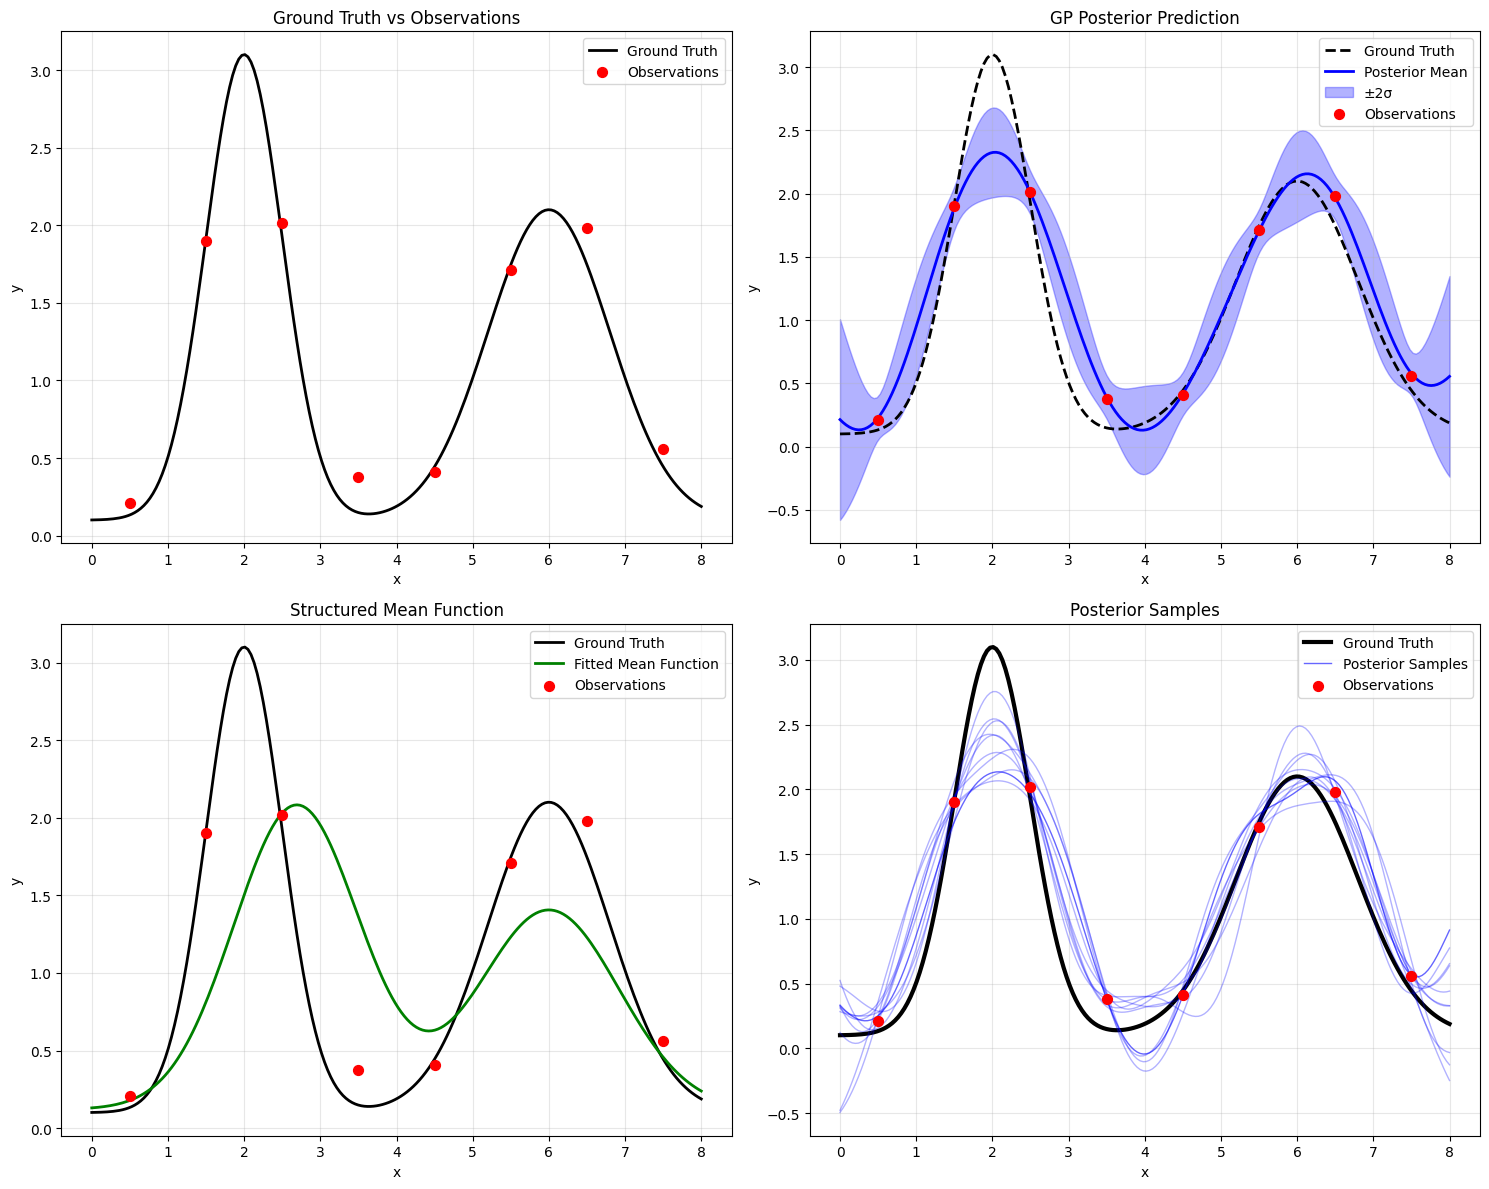

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Data and Ground Truth
ax1 = axes[0, 0]
ax1.plot(x_test_np, y_true, 'k-', linewidth=2, label='Ground Truth')
ax1.scatter(x_obs.numpy(), y_obs.numpy(), c='red', s=50, zorder=5, label='Observations')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Ground Truth vs Observations')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Posterior Prediction
ax2 = axes[0, 1]
ax2.plot(x_test_np, y_true, 'k--', linewidth=2, label='Ground Truth')
ax2.plot(x_test_np, mean.numpy(), 'b-', linewidth=2, label='Posterior Mean')
ax2.fill_between(x_test_np, 
                (mean - 2*std).numpy(), 
                (mean + 2*std).numpy(), 
                alpha=0.3, color='blue', label='±2σ')
ax2.scatter(x_obs.numpy(), y_obs.numpy(), c='red', s=50, zorder=5, label='Observations')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('GP Posterior Prediction')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Mean Function vs Ground Truth
ax3 = axes[1, 0]
ax3.plot(x_test_np, y_true, 'k-', linewidth=2, label='Ground Truth')
ax3.plot(x_test_np, mean_func_pred.numpy(), 'g-', linewidth=2, label='Fitted Mean Function')
ax3.scatter(x_obs.numpy(), y_obs.numpy(), c='red', s=50, zorder=5, label='Observations')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('Structured Mean Function')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Posterior Samples
ax4 = axes[1, 1]
ax4.plot(x_test_np, y_true, 'k-', linewidth=3, label='Ground Truth')
for i in range(num_samples):
    alpha = 0.6 if i == 0 else 0.3
    label = 'Posterior Samples' if i == 0 else None
    ax4.plot(x_test_np, samples[i].numpy(), 'b-', alpha=alpha, linewidth=1, label=label)
ax4.scatter(x_obs.numpy(), y_obs.numpy(), c='red', s=50, zorder=5, label='Observations')
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title('Posterior Samples')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 8. PARAMETER COMPARISON TABLE


In [9]:

print("\n" + "="*60)
print("PARAMETER COMPARISON: TRUE vs FITTED")
print("="*60)

true_params = {
    'Peak 1 Amplitude': 3.0,
    'Peak 1 Center': 2.0, 
    'Peak 1 Width': 0.5,
    'Peak 2 Amplitude': 2.0,
    'Peak 2 Center': 6.0,
    'Peak 2 Width': 0.8,
    'Baseline': 0.1
}

fitted_params = {
    'Peak 1 Amplitude': mean_module.amp1.item(),
    'Peak 1 Center': mean_module.center1.item(),
    'Peak 1 Width': mean_module.width1.item(),
    'Peak 2 Amplitude': mean_module.amp2.item(),
    'Peak 2 Center': mean_module.center2.item(),
    'Peak 2 Width': mean_module.width2.item(),
    'Baseline': mean_module.baseline.item()
}

print(f"{'Parameter':<20} {'True':<10} {'Fitted':<10} {'Error':<10}")
print("-" * 50)
for param in true_params:
    true_val = true_params[param]
    fitted_val = fitted_params[param]
    error = abs(true_val - fitted_val) / true_val * 100
    print(f"{param:<20} {true_val:<10.3f} {fitted_val:<10.3f} {error:<10.1f}%")

print("\n" + "="*60)
print("INFERENCE COMPLETE!")
print("="*60)


PARAMETER COMPARISON: TRUE vs FITTED
Parameter            True       Fitted     Error     
--------------------------------------------------
Peak 1 Amplitude     3.000      1.960      34.7      %
Peak 1 Center        2.000      2.690      34.5      %
Peak 1 Width         0.500      0.824      64.9      %
Peak 2 Amplitude     2.000      1.284      35.8      %
Peak 2 Center        6.000      6.001      0.0       %
Peak 2 Width         0.800      0.915      14.4      %
Baseline             0.100      0.121      20.9      %

INFERENCE COMPLETE!
